In [43]:
import numpy as np
import pandas as pd

In [44]:
df = pd.read_csv('../data/userDataRecency.csv')

df['time_of_day'] = pd.Categorical(df['time_of_day'], categories=['Morning', 'Afternoon', 'Evening', 'Night'])
df

,food_name,time_of_day,recency_days
0,scoop of optimum nutrition protein powder,Morning,1.0
1,cups of milk,Morning,1.0
2,black coffee,Morning,1.0
3,cup of milk,Morning,1.0
4,chicken tacos,Evening,1.0
...,...,...,...
382,fairlife 2 percent chocolate milk,Evening,0.0
383,chicken,Evening,0.0
384,small flour tortillas,Evening,0.0
385,2 percent fairlife chocolate milk,Evening,0.0


In [45]:
# Label encoding
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
# import graphviz

encoder = LabelEncoder()
encoder.fit(df['food_name'])



LabelEncoder()

In [46]:

y = df['food_name']
# print(y)

y = encoder.transform(y)


encodedX = pd.get_dummies(df, columns=['time_of_day'])

X = encodedX.drop(columns=['food_name'])

encodedX


,food_name,recency_days,time_of_day_Morning,time_of_day_Afternoon,time_of_day_Evening,time_of_day_Night
0,scoop of optimum nutrition protein powder,1.0,True,False,False,False
1,cups of milk,1.0,True,False,False,False
2,black coffee,1.0,True,False,False,False
3,cup of milk,1.0,True,False,False,False
4,chicken tacos,1.0,False,False,True,False
...,...,...,...,...,...,...
382,fairlife 2 percent chocolate milk,0.0,False,False,True,False
383,chicken,0.0,False,False,True,False
384,small flour tortillas,0.0,False,False,True,False
385,2 percent fairlife chocolate milk,0.0,False,False,True,False


In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


rf = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42, min_samples_leaf=5)

rf.fit(X, y)

# Sample data

times_of_day = ['Morning', 'Afternoon', 'Evening', 'Night']

# Generate all possible combinations of day and time
all_permutations = list(times_of_day)

# print(all_permutations)

# Create a DataFrame to store the permutations
manual_test = pd.DataFrame(all_permutations, columns=['time_of_day'])
manual_encoded = pd.get_dummies(manual_test, columns=['time_of_day'])

manual_encoded['recency_days'] = 1

manual_encoded = manual_encoded[X.columns]


y_pred_proba = rf.predict_proba(manual_encoded)

# Specify how many top predictions you want to consider
top_n = 5
# Get the indices of the top N predictions for each sample
top_n_indices = (-y_pred_proba).argsort(axis=1)[:, :top_n]

# Get the top N predictions for each sample
top_n_predictions = rf.classes_[top_n_indices]

top_n_predictions_labels = top_n_predictions.copy()

top_n_predictions_labels = top_n_predictions_labels.flatten()

top_n_predictions_labels = encoder.inverse_transform(top_n_predictions_labels)

top_n_predictions_labels = top_n_predictions_labels.reshape(top_n_predictions.shape)


In [48]:

# Assuming you have stored the day and time_of_day columns separately
# day_cols = ['weekday_Monday', 'weekday_Tuesday', 'weekday_Wednesday', 'weekday_Thursday', 'weekday_Friday', 'weekday_Saturday', 'weekday_Sunday']
time_cols = ['time_of_day_Morning', 'time_of_day_Afternoon', 'time_of_day_Evening', 'time_of_day_Night']

# Print the top N predictions for each sample along with their parameters and probabilities

result = []

with open("../out/recency_forest.txt", "w") as f:
    for i in range(len(manual_encoded)):
        # day = [col.split('_')[1] for col in day_cols if manual_encoded.iloc[i][col] == 1][0]
        time_of_day = [col.split('_')[3] for col in time_cols if manual_encoded.iloc[i][col] == 1][0]

        # f.write("Day: {}\n".format(day))
        f.write("Time of Day: {}\n".format(time_of_day))
        f.write("Predictions:\n")
        for j in range(top_n):
            f.write("    - Prediction {}: {}, Probability: {:.2f}%\n".format(j + 1, top_n_predictions_labels[i][j], y_pred_proba[i][top_n_indices[i][j]] * 100))
        f.write("\n")
        result.append({
            # 'day': day,
            'time_of_day': time_of_day,
        })
        for j in range(top_n):  # Assuming you want top 5 predictions
            result[-1][f'prediction{j+1}'] = top_n_predictions_labels[i][j]
            result[-1][f'probability{j+1}'] = y_pred_proba[i][top_n_indices[i][j]] * 100

df_result = pd.DataFrame(result)
df_result

,time_of_day,prediction1,probability1,prediction2,probability2,prediction3,probability3,prediction4,probability4,prediction5,probability5
0,Morning,cups of milk,22.625434,starbucks caramel macchiato,7.108690,chipotle chicken and queso bowl,6.820109,cup of milk,6.623482,scoop of optimum nutrition protein powder,6.581865
1,Afternoon,starbucks caramel macchiato,5.539801,cups of milk,5.011230,sweet tea,4.448558,kodiak cake waffles,4.169158,chick-fil-a sandwich,4.082053
2,Evening,chick-fil-a sandwich,5.940746,chicken tacos,5.249278,chick-fil-a granola parfait,5.026619,chick-fil-a breakfast burrito,3.051157,chick-fil-a sweet tea,2.997048
3,Night,kodiak cake waffles,8.162813,cups of milk,5.029583,sweet tea,4.927432,chick-fil-a sandwich,4.897888,starbucks caramel macchiato,3.931848


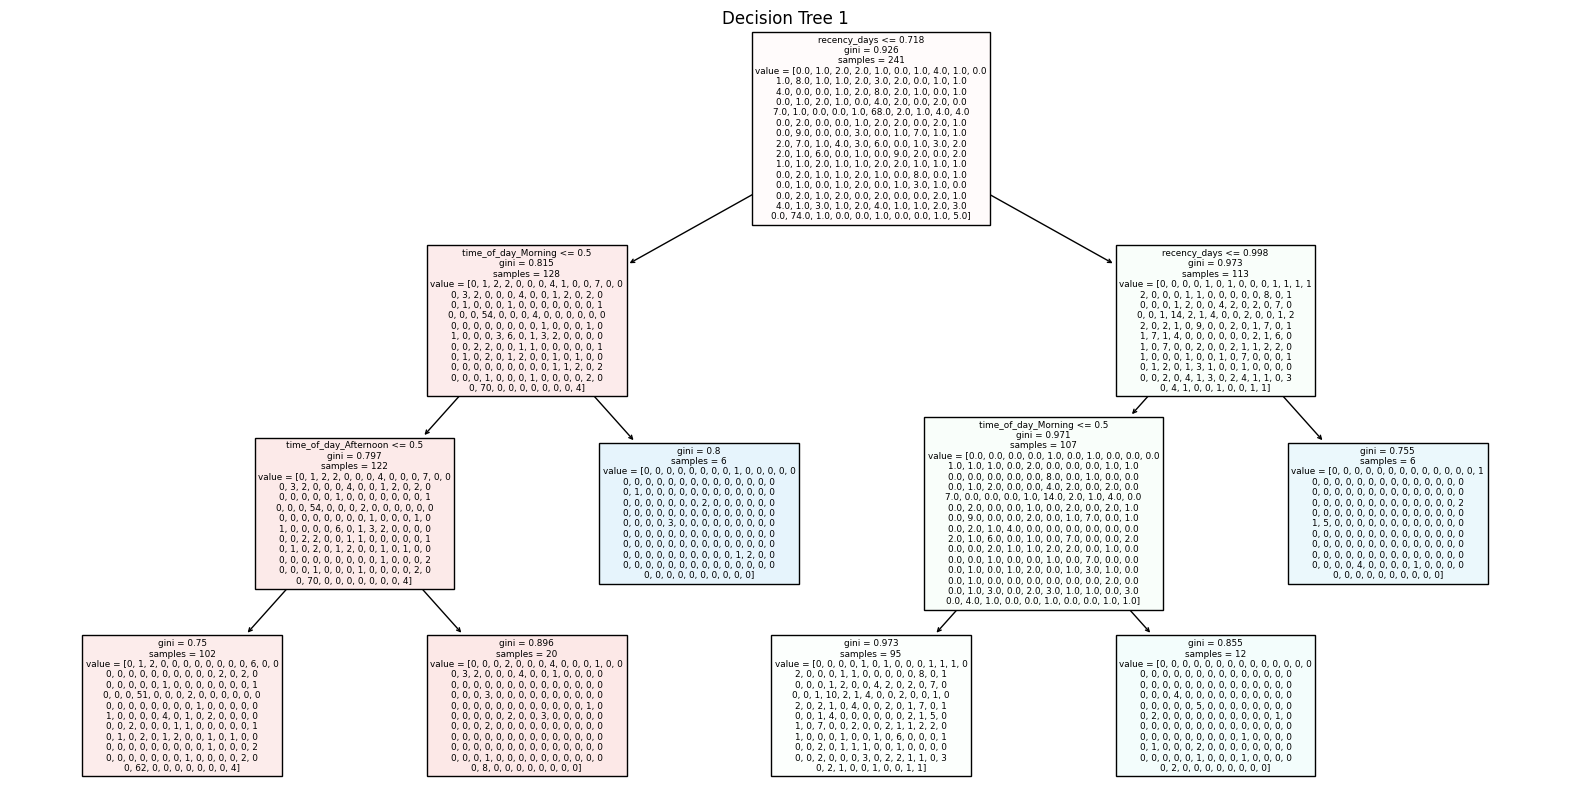

In [50]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Assuming rf is your RandomForestClassifier object

# Assuming rf is your RandomForestClassifier object

plt.figure(figsize=(20, 10))  # Adjust the figure size as needed
tree = rf.estimators_[0]  # Selecting the first decision tree
plot_tree(tree, feature_names=X.columns, filled=True, max_depth=3)
plt.title("Decision Tree 1")
plt.show()